<a href="https://colab.research.google.com/github/DeniGarnica/SGI-MIT/blob/main/SGI_2022_Julia_aproximation_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The only 2 things to change is the URL of the image, and the original roots with the vector of multiplicities to run everything with another set.

#Importing objective and libraries

In [ ]:
#import all required libraries
import torch
import numpy as np 
import requests
import math
from PIL import Image 
import random
import time 
import matplotlib
from matplotlib import pyplot as plt
import tensorflow as tf

#Import image

#imgurl =  "https://i.ibb.co/7GQn1vX/Ob4.png"

imgurl = "https://i.ibb.co/4fDKfxj/Ob3.png"

In [ ]:
#Original roots
#WE just need this to plot the original Set
r_original = [torch.Tensor([[  0.0,  -1],
         [ -1, 0.5],
         [1,  0.500],
         [0,  0.05]
       ]), torch.Tensor([[1.00,  1.00]])]

m_original = np.array([2, 2, 2, 2, 0.01])
print(m_original)

[2.   2.   2.   2.   0.01]


In [ ]:
ground_truth = Image.open(requests.get(imgurl, stream=True).raw)

Now we are trying to approximate this figure:



Downloaded ground_truth image:


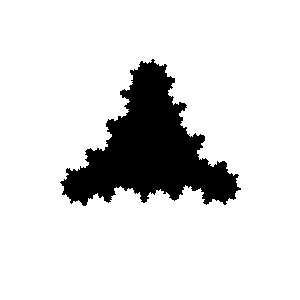

In [ ]:
# Resize to square image for ease of bucketing 
ground_truth = ground_truth.resize((ground_truth.height, ground_truth.width))
print("Downloaded ground_truth image:")
display(ground_truth)

In [ ]:
N = 50 
# We convert the PIL image to a PyTorch tensor so we can use pytorch functions on them 
imgtensor = torch.from_numpy(np.asarray(ground_truth))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
cell_width = imgtensor.shape[1]//N 
cell_height = imgtensor.shape[0]//N 

In [ ]:
occgrid = torch.zeros((N, N))
for w in range(N): 
  for h in range(N): 
    # If any pixel within our cell_width x cell_height grid is not white, then we call the cell "occupied"
    occgrid[h, w] = torch.any(imgtensor[h * cell_height:(h+1) * cell_height, w * cell_width:(w+1) * cell_width] != 0)
    ## Note this is an extremely greedy definition, since most of the cell can still be white and have a occupancy of 1 

In [ ]:
# `occgrid` is now our "ground truth" labels 
# Visualize occupancies 
occgrid_rgb = torch.ones((N, N, 3)) * 255
occgrid_rgb *= occgrid.unsqueeze(2)
occgrid_img = Image.fromarray(np.uint8(occgrid_rgb.long().numpy()))

50x50 Occupancy approximation:


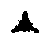

In [ ]:
print(f"{N}x{N} Occupancy approximation:")
display(occgrid_img)

#Useful Functions

In [ ]:
#This returns the squares adjacent to the input square
def adjacent(A, i, j):
    M = len(A[0]) - 1
    N = len(A) - 1
    r = []
    if(i>0):
        r.append(A[i-1][j])
        if(j>0):
            r.append(A[i-1][j-1])
        if(j<M):
            r.append(A[i-1][j+1])
    if(i<N):
        r.append(A[i+1][j])
        if(j>0):
            r.append(A[i+1][j-1])
        if(j<M):
            r.append(A[i+1][j+1])
    if(j>0):
        r.append(A[i][j-1])
    if(j<M):
        r.append(A[i][j+1])
    
    return r

In [ ]:
#We pass the grid and will return an array with the positions (i,j) that are on the boundry of the figure
def find_boundary(occgrid):
    N = len(occgrid)
    #it will mark with ones the boundry
    boundary = torch.zeros((N, N)) 
    boundary_2 = [] #will have de coordinates of the boundry
    adjacent_b = torch.zeros((N, N)) 
    adjacent_b2 = []
    for i in range(N):
        for j in range(N):
            r = adjacent(occgrid, i, j)
            for k in r:
                if occgrid[i][j] !=  k:
                    if occgrid[i][j] == 1: #this means is in the boundary
                        boundary[i][j] = 1
                        boundary_2.append(np.array([i, j]))
                    else: #it is outside but beside the boundary
                        adjacent_b[i][j] = 1
                        adjacent_b2.append(np.array([i, j]))
                    break
    return torch.tensor(boundary_2), torch.tensor(adjacent_b2)

In [ ]:
# unction to return center pixel of the specificed square, normalized
def center_pixel(p, N):
  i = p[0]
  j = p[1]
  a = N/2
  i = (i+0.5-a)/a
  j = (j+0.5-a)/a
  d = [i,j]
  t_d = torch.tensor(d)
  return t_d

In [ ]:
random.seed(time.time())

#we pass the grid and the number of top and bottom roots
def random_roots(occgrid, n_toproots, n_bottomroots, T):
    boundary, adjacent_b = find_boundary(occgrid)
    N = len(boundary)
    M = len(adjacent_b)
    t_r = torch.zeros((n_toproots, 2))
    b_r = torch.zeros((n_bottomroots, 2)) 
    for i in range(n_toproots):
        r = random.randint(0, N-1)
        t_r[i] = center_pixel(boundary[r], T)*(0.8) #we multiply to make it closer to the center

    for i in range(n_bottomroots):
        r = random.randint(0, M-1)
        b_r[i] = center_pixel(adjacent_b[r], T)*(1.2) #we multiply to make it further to the center
    
    return t_r, b_r

In [ ]:
# returns normalized occupancy prediction based on the norms of the points in the Julia set
def predict_occupancies(r, query_points, threshold, M):
  julia_set_point = generateJuliaSet(r, query_points, C, M)
  predicted_norms = torch.linalg.norm(julia_set_point, dim=1)
  aux = (threshold-predicted_norms)/threshold
  occupancy_predictions = (torch.tanh(aux) + 1)/2

  return occupancy_predictions

In [ ]:
# Convert 2D tensor to 1D complex tensor 
def convertToComplex(t): 
  ret = []
  for val in t: 
    ret.append(torch.complex(val[0], val[1]))
  return torch.stack(ret)

In [ ]:
# Here's a function for making sure things don't explode
class ZeroNanGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return x

    @staticmethod
    def backward(ctx, grad):
        grad[grad != grad] = 0
        return grad

#Creating the grid

In [ ]:
def create_grid(occgrid, show_grid): 
  occgrid_midpoints = torch.zeros((len(occgrid),len(occgrid[0]),2)) #initializing the occgrid_midpoints to be a tensor of 0s
  # center_pixel outputs a tensor (of the midpoint coordinate) and we need the occgrid_midpoints to take in the tensor
  for j in range(len(occgrid)):
    for i in range(len(occgrid[j])): 
      occgrid_midpoints[j][i] = center_pixel(torch.tensor([j,i]),N)
  query_points = torch.clone(occgrid_midpoints)

  #function to display the occgrid_midpoints
  if(show_grid):
    print("Original grid") 
    p_x = []
    p_y = []
    for i in range(len(occgrid_midpoints)):
      for j in range(len(occgrid_midpoints[j])):
        p_x.append(float(occgrid_midpoints[j][i][0])) 
        p_y.append(float(occgrid_midpoints[j][i][1]))
    plt.plot(p_x, p_y, '.')

  return query_points

#Functions for the Julia set

In [ ]:
#creates the generating function with the random roots and the constant e^C and the vector of multiplicities M
def f(random_roots, q, M, C):
  top = random_roots[0]
  bottom = random_roots[1]
  result_t = torch.complex(torch.Tensor([1]),torch.Tensor([1]))
  result_b = torch.complex(torch.Tensor([1]),torch.Tensor([1]))
  
  for i in range(len(top)):
      result_t *= (q - top[i]) ** M[i]
  for i in range(len(bottom)):
      result_b /= (q - bottom[i]) ** M[i + len(top)]
  return result_t/(result_b + torch.complex(torch.Tensor([1e-4]), torch.Tensor([1e-4]))) * (math.e**C)

In [ ]:
def inJuliaSet(q0, max_iter, M, C):
  # We can set fairly low values for the divergence threshold and maximum recursions to check to still get something good 
  threshold = 2 
  count = 0
  q = q0
  while torch.linalg.vector_norm(torch.tensor(q)) < threshold and count < max_iter:
  #if the norm does not exceed the threshold and we are within the maximum number iterations, we proceed
    q = f(q, M, C) #calling the generating function 
    count += 1
  if count >= max_iter: #
    return True, 0
  else: 
    return False, count

In [ ]:
def generateJuliaSet(r, query_points, C, M):
  a = torch.zeros_like(query_points) # W x H array of complex numbers 
  for i in range(query_points.shape[0]):
    for j in range(query_points.shape[1]):
      a[i, j] = f(r, query_points[i,j], M, C)

  return a #returns a list of the outputs of the function evaluated at each query point in the input list 

#Functions to Plot

In [ ]:
def create_f(r0, r1):
    rt = []
    rb = []
    n_t = len(r0)
    n_b = len(r1)
    r_x = []
    r_y = []

    i = complex(0,1)

    #Save the top roots
    for j in range(n_t):
        rt.append(r0[j][0] + r0[j][1]*i)
        r_x.append(r0[j][0])
        r_y.append(r0[j][1])

    #Save the bottom roots
    for j in range(n_b):
        rb.append(r1[j][0] + r1[j][1]*i)
        r_x.append(r1[j][0])
        r_y.append(r1[j][1])
        
    #just plotting the roots
    print("Lets see the roots of the set")
    import plotly.express as px
    fig = px.scatter(x = r_x, y = r_y)
    fig.update_layout(autosize=False, width=300, height=300)
    fig.show()
    
    def f(q, m):
        result_t = 1
        result_b = 1
        for i in range(n_t):
            if(m[i] >= 0):
                result_t *= (q-rt[i])**m[i]
            else:
                result_b *= (q-rt[i])**(-m[i])
        for i in range(n_b):
            if(m[i] >= 0):
                result_b *= (q-rb[i])**m[i+n_t]
            else:
                result_t *= (q-rb[i])**(-m[i+n_t])
        else:
            return result_t
    
    
    return f, r_x, r_y

In [ ]:
def inJuliaSetPlot(f, q0, m, max_iter):
  # We can set fairly low values for the divergence threshold and maximum recursions to check to still get something good 
    threshold = 2 
    count = 0
    q = q0
    while np.linalg.norm(q) < threshold and count < max_iter: 
        q = f(q, m) 
        count += 1
    if count >= max_iter: 
        return True, 0
    else: 
        return False, count

In [ ]:
def exportImage(img: np.ndarray, filename: str, show=False):
    from PIL import Image 
    img = Image.fromarray(img.astype("uint8"), 'RGB')
    if show: 
        display(img)
    img.save(f"{filename}.png")

In [ ]:
def plot(f, m, R, max_iter, n_t, n_b, r_x, r_y):
    # Boundaries of Julia set to compute using rationals 
    xRes = 75
    yRes = 75
    # Boundaries of image to set center as (0,0)
    xbound = 150
    ybound = 150
    
    color = [21, 61, 57] #add the color you like to start with
    print("The Julia Set")
    if not R:
        color = [255, 255, 255]

    img = np.zeros((xbound*2, ybound*2, 3))
    for x in range(-xbound, xbound):
        for y in range(-ybound, ybound): 
            aux = inJuliaSetPlot(f, complex(x/xRes, y/yRes), m, max_iter)
            if not aux[0]:
                c = aux[1] 
                img[ybound + y, xbound + x] = np.array([(color[0] +c*(255-color[0])/(2*max_iter)), (color[1] + c*(255-color[1])/max_iter), (color[2] + c*(255-color[2])/max_iter)])
    if R:
        for i in range(n_t):
            img[int(ybound + np.ceil(r_y[i]*yRes)), int(xbound + np.ceil(r_x[i]*xRes))] = np.array([167, 242, 241]) 
            img[int(ybound + np.ceil(r_y[i]*yRes)) + 1, int(xbound + np.ceil(r_x[i]*xRes))] = np.array([167, 242, 241]) 
            img[int(ybound + np.ceil(r_y[i]*yRes)) - 1, int(xbound + np.ceil(r_x[i]*xRes))] = np.array([167, 242, 241])
            img[int(ybound + np.ceil(r_y[i]*yRes)), int(xbound + np.ceil(r_x[i]*xRes)) + 1] = np.array([167, 242, 241])
            img[int(ybound + np.ceil(r_y[i]*yRes)), int(xbound + np.ceil(r_x[i]*xRes)) - 1] = np.array([167, 242, 241])

        for j in range(n_b):
            i = j+n_t
            img[int(ybound + np.ceil(r_y[i]*yRes)), int(xbound + np.ceil(r_x[i]*xRes))] = np.array([255, 0, 0]) 
            img[int(ybound + np.ceil(r_y[i]*yRes)) + 1, int(xbound + np.ceil(r_x[i]*xRes))] = np.array([255, 0, 0]) 
            img[int(ybound + np.ceil(r_y[i]*yRes)) - 1, int(xbound + np.ceil(r_x[i]*xRes))] = np.array([255, 0, 0]) 
            img[int(ybound + np.ceil(r_y[i]*yRes)), int(xbound + np.ceil(r_x[i]*xRes)) + 1] = np.array([255, 0, 0]) 
            img[int(ybound + np.ceil(r_y[i]*yRes)), int(xbound + np.ceil(r_x[i]*xRes)) - 1] = np.array([255, 0, 0]) 
    exportImage(img, 'example', True)

# Optimization functions

In [ ]:
def for_opti(query_points, r):
  complex_query_points = torch.ones((query_points.shape[0], query_points.shape[1]), dtype=torch.complex64)
  for i in range(query_points.shape[0]):
    for j in range(query_points.shape[1]):
      complex_query_points[i,j] = torch.complex(query_points[i,j,0], query_points[i,j,1]) #converting all to torch complex numbers
  
  complex_r_top = [] 
  for topr in r[0]: 
    complex_r_top.append(torch.complex(topr[0], topr[1]))
  complex_r_bot = [] 
  for botr in r[1]: 
    complex_r_bot.append(torch.complex(botr[0], botr[1]))
  complexr = (torch.stack(complex_r_top), torch.stack(complex_r_bot))

  return complex_query_points, complexr

In [ ]:
def opti(occgrid, n_iters, n_epochs, r, show_loss, show_M, show_grid, threshold, C):
  query_points = create_grid(occgrid, show_grid)
  complex_query_points, complexr =  for_opti(query_points, r)
  target_occupancy = occgrid

  t = len(r[0])
  b = len(r[1])

  # This initializes our multiplicity parameter M to be a torch tensor (vector) of all ones. 
  #Note `requires_grad = True` means that any operations using M will require a gradient calculation, 
  #which will allow us to backprop the loss during optimization. 
  M = torch.nn.Parameter(torch.ones(t + b, requires_grad=True)) 

  opt = torch.optim.SGD([M], lr=0.1, momentum=0.9) #optimization settings


  # Note that since the roots are randomly selected, performance can vary significantly between optimizations
  for epoch in range(n_epochs):
    opt.zero_grad() #this sets the value of the grads to None
    jitter = torch.complex(torch.rand(query_points.shape[:2]), torch.rand(query_points.shape[:2])) * 0.01 #Jitter query_points with some noise to avoid issue when q == root in the denominator
    epoch_query_points = torch.clone(complex_query_points) + jitter 

    occupancy_predictions = predict_occupancies(complexr, epoch_query_points, threshold, M)
    # check whether query points are in julia set 
    #   step 1. calculate the norm at that point
    #   step 2. map norms to [0,1] range
    
    # comparing "target" to "predictions"
    occupancy_loss = torch.mean((occupancy_predictions - occgrid)**2) 
    if(show_loss and epoch%5==0): #Just print the loss every 5 epochs
      print(f"Loss {occupancy_loss}") 
    if(show_M and epoch%5==0): #Just print the M every 5 epochs
      print(M)

    occupancy_loss.backward() 
    opt.step() 

  return M

#Original Set

In [ ]:
n_iters = 30 # Number of iterations to run each Julia set recursion for 
#change number of iteration to 10 or 5 if you want to run the program faster 
n_epochs = 100 # Number of epochs to run optimization 

# Fix Julia set parameters (recall we fix C, |T|, |B|, and the root positions, so the only thing that will be shifting are the multiplicities 
C = 0 #this will be in the equation as e^C, a constant factor in the equation 
t = len(r_original[0]) #this is the number of the top roots
b = len(r_original[1]) #this is the number of bottom roots
threshold = 2 #threshold against which we compare the norm of the output of the generating functions

In [ ]:
#Original roots
r0 = r_original[0].numpy()
r1 = r_original[1].numpy()

#Real multiplicity
m = m_original
print(m)

[2.   2.   2.   2.   0.01]


Lets see the roots of the set


The Julia Set


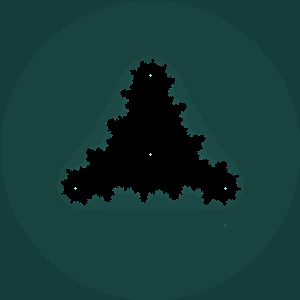

In [ ]:
f_plot, r_x, r_y = create_f(r0, r1)
n_t = len(r0)
n_b = len(r1)
max_iter = n_iters
plot(f_plot, m, 1, max_iter, n_t, n_b, r_x, r_y)

The code below plots the results of the optimization

#Running Optimization with Original Roots

In [ ]:
# This information can be used to plot the resulting set
M = opti(occgrid, n_iters, n_epochs, r_original, 0, 0, 0, threshold, C)

In [ ]:
M

Parameter containing:
tensor([-0.3353, -2.6246,  0.5006,  2.7098, -0.2532], requires_grad=True)

Here we have the plot of the original roots without knowing the M parameters before the optimization

In [ ]:
m = np.ones(n_t+n_b)
print(m)

[1. 1. 1. 1. 1.]


Lets see the roots of the set


The Julia Set


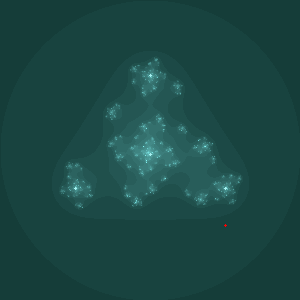

In [ ]:
f_plot, r_x, r_y = create_f(r0, r1)
n_t = len(r0)
n_b = len(r1)
max_iter = n_iters
plot(f_plot, m, 1, max_iter, n_t, n_b, r_x, r_y)

Original roots with optimization

In [ ]:
m = M.detach().numpy()
print(m)

[-0.3353455 -2.6245694  0.5005708  2.709817  -0.2532425]


Lets see the roots of the set


The Julia Set


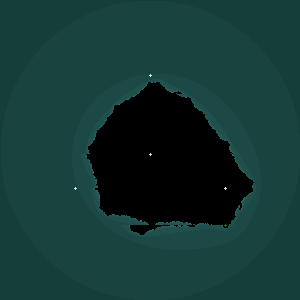

In [ ]:
f_plot, r_x, r_y = create_f(r0, r1)
n_t = len(r0)
n_b = len(r1)
max_iter = n_iters
plot(f_plot, m, 1, max_iter, n_t, n_b, r_x, r_y)

##Running Optimization with Random Roots

In [ ]:
#creating the random roots 
r = random_roots(occgrid, t, b, N)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



In [ ]:
r[0][0] = torch.Tensor([0.0,  0.0]) #This adds a root at the origin to clean up the image

In [ ]:
r

(tensor([[ 0.0000,  0.0000],
         [ 0.2400, -0.3040],
         [ 0.2080, -0.4640],
         [ 0.2400,  0.0800]]), tensor([[-0.3120, -0.1200]]))

Now lets do it using random roots 

In [ ]:
# This information can be used to plot the resulting set
M = opti(occgrid, n_iters, n_epochs, r, 0, 0, 0, threshold, C)

In [ ]:
M

Parameter containing:
tensor([ 1.7921,  0.5439,  0.5151,  2.8584, -1.2002], requires_grad=True)

In [ ]:
#Using random roots
r0 = r[0].numpy()
r1 = r[1].numpy()
m = np.ones(n_t+n_b)
print(r0, r1)
print(m)

[[ 0.          0.        ]
 [ 0.24000001 -0.304     ]
 [ 0.20799999 -0.464     ]
 [ 0.24000001  0.08000001]] [[-0.312 -0.12 ]]
[1. 1. 1. 1. 1.]


Before the optimization

Lets see the roots of the set


The Julia Set


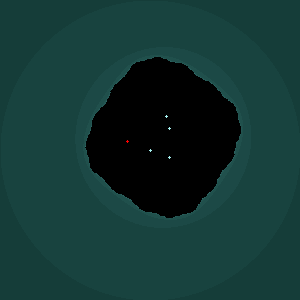

In [ ]:
f_plot, r_x, r_y = create_f(r0, r1)
n_t = len(r0)
n_b = len(r1)
max_iter = n_iters
plot(f_plot, m, 1, max_iter, n_t, n_b, r_x, r_y)

After the optimization

In [ ]:
m = M.detach().numpy()
print(m)

[ 1.7920876  0.5439102  0.5150975  2.8584037 -1.2002412]


Lets see the roots of the set


The Julia Set


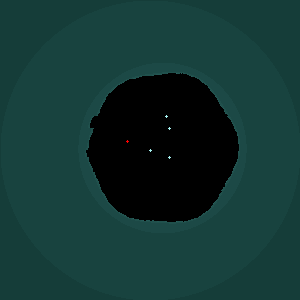

In [ ]:
f_plot, r_x, r_y = create_f(r0, r1)
n_t = len(r0)
n_b = len(r1)
max_iter = n_iters
plot(f_plot, m, 1, max_iter, n_t, n_b, r_x, r_y)